<a href="https://colab.research.google.com/github/NicholasBaraghini/Machine-Learning-for-Computer-Vision-LAB-Sessions/blob/main/ML4CV_3_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start with our usual imports and figure adjustments.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from timeit import default_timer as timer
from functools import partial

plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 16

We then download the CIFAR10 dataset, as usual. Since we are still processing images as vectors with a linear classifier, we add a `torchvision.transforms.Transform` to reshape them as vectors already when we load them into the `Dataset` class. `Transform`s are pre-processing operations we apply on each of our item before returning them. 

We were already using a `Transform` in the previous notebooks: `ToTensor`. To load images from files, pytorch uses an image processing library, like OpenCV. It does not uses OpenCV, though, but PIL, the Python Image Library. `ToTensor` then converts an image from the PIL format to a PyTorch `Tensor`. It also makes sure the entries of the tensor are in $[0,1]$ by dividing them by $255$.

To reshape tensors to have only one dimension, we use a `LambdaTransform`: it is a generic transform that you can use to realize a transformation not already implemented in PyTorch. 

Finally, we use `Transform.Compose` to chain single transformatioms into a pipeline. 

In [ ]:
trsfms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda z: z.reshape(-1))]) 
train_ds = torchvision.datasets.CIFAR10(root="/data/", train=True, transform=trsfms, download=True)
test_ds = torchvision.datasets.CIFAR10(root="/data/", train=False, transform=trsfms)

classes = train_ds.classes
n_classes = len(classes)
n_features = len(train_ds[0][0])
n_classes, n_features

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data/


(10, 3072)

We split the training dataset as usual.

In [ ]:
splitted_datasets = torch.utils.data.random_split(train_ds, [45000, 5000])
actual_train_subds = splitted_datasets[0]
valid_subds = splitted_datasets[1]

This time we do not transfer input images into a feature matrix, as we will finally use `DataLoader`s. To create smaller datasets to use while developing and for initial testing, we explicitly create `torch.utils.data.Subset`s. 

A `Subset` is a collection of indexes over a `Dataset`. It can be used everywhere a `Dataset` can.

In [ ]:
small_actual_train_subds = torch.utils.data.Subset(actual_train_subds, range(500))
small_valid_subds = torch.utils.data.Subset(valid_subds, range(100))
small_test_subds = torch.utils.data.Subset(test_ds, range(100))

We are finally ready to create `torch.utils.data.DataLoader`s. A `DataLoader` makes it easy to implement mini-batch SGD. A DataLoader is an iterable object, i.e. you can use it in a `for` loop. It iterates over a `Dataset`, one mini-batch of size `batch_size` at the time. 

Let's create first a DataLoader to experiment with it.

In [ ]:
probe_dl = torch.utils.data.DataLoader(small_test_subds, batch_size=16, shuffle=True)

In [ ]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')

Everytime you use a `DataLoader` (or another iterable) in a `for` loop, Python creates and `iter`ator around it and calls the function `next()` on it. This is what we simulate in this cell. Everytime you execute it, you will get a new minibatch. 

Each mini-batch is a list of two `Tensor`s, storing 16 items $x^{(i)}$ and their 16 labels $y^{(i)}$, respectively.

<class 'list'> 2 <class 'torch.Tensor'> torch.Size([16, 3072]) <class 'torch.Tensor'> torch.Size([16])
['ship', 'automobile', 'airplane', 'ship', 'frog', 'truck', 'cat', 'truck', 'deer', 'frog', 'cat', 'airplane', 'dog', 'airplane', 'truck', 'cat']


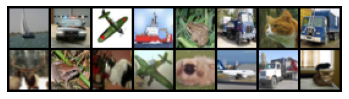

In [ ]:
data = next(iter(probe_dl))
print(type(data), len(data), type(data[0]), data[0].shape, type(data[1]), data[1].shape)
show(torchvision.utils.make_grid(data[0].reshape(-1,3,32,32)))
print(list(map(lambda x: classes[x], data[1])))

Anotehr useful property of a `DataLoader` is its length, which you can retrieve with `len`, as you would do on any other collection. It returns the number of mini-batches, and therefore of **parameter updates** that you will perform when training with this `DataLoader`.

In this case, we expect to obtain $\lceil \frac{100}{16} \rceil=7$ mini-batches.

In [ ]:
len(probe_dl)

7

Let's now create the `DataLoader`s we need. Three small ones for quick experimentation, wrapping the `Subset`s we created before, and three full size ones, to use at the end.

We will fix `batch_size` to 128. Try to vary it to see its effect!

**IMPORTANT**: notice that we set `shuffle=True` for the training `DataLoader`s. It is important to remember it. With `shuffle=True`, after every epoch, i.e. after having returned all the items in the underlying `Dataset`, items will be shuffled within the DataLoader to produce new minibatches in the next epoch.

In [ ]:
batch_size = 128
small_actual_train_dl = torch.utils.data.DataLoader(small_actual_train_subds, batch_size=batch_size, shuffle=True)
small_valid_dl = torch.utils.data.DataLoader(small_valid_subds, batch_size=batch_size)
small_test_dl = torch.utils.data.DataLoader(small_test_subds, batch_size=batch_size)
actual_train_dl = torch.utils.data.DataLoader(actual_train_subds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_subds, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

We then define the same linear classifier we introduced in the previous lecture. For convinience, this time we create a class which holds together the random initialization in the `__init__` method (which also tells PyTorch to compute gradients for `W` and `b`), and the method to classify new data, which we call `forward`, since it implements the forward pass of GD/SGD. This is also the convention used by other classes in PyTorch, as we shall see. 

Note we use the small value for the standard deviation at initialization, as we discussed in the last lecture.

We also add a `set_params` method to load params computed after training into a test model.

In [ ]:
class LinearClassifier:
  def __init__(self, n_features, n_classes):
      self.W = torch.normal(0, 0.0001, (n_features, n_classes)).requires_grad_()
      self.b = torch.zeros(n_classes).requires_grad_()

  def forward(self, batch):
    return torch.matmul(batch, self.W) + self.b

  def set_params(self, W, b):
    if self.W.shape != W.shape or self.b.shape != b.shape:
      raise ValueError("Shape of input Tensors not compatible with classifier shape")
    self.W=W
    self.b=b

We can now implement SGD (with minibatches). Using `DataLoader`s the loop is very similar to the standard GD loop we wrote in the previous lecture.

In each epoch, we loop over the mini-batches returned by the `train_dl`. We then perform the usual pipeline of calling `forward`, then `loss`, then `backward`, then update params, then zero the gradients. 

Training loss is computed (and averaged over) each mini-batch. To accumulate it correctly in order to compute the loss over the full training (or validation) set, we need to multiply it back for the number of items in a mini-batch and keep track of how many items we have processed.

After each epoch completes, we compute the validation statistics. Splitting data into mini-batches is not really needed here, as we will simply call foward and evlauate the results on each item of the set. Yet, this will become the most efficient way to compute validation stats when we will  be using larger models and datasets on GPUs. Hence, we will start using it immediately to get used to it.


In [ ]:
def ncorrect(scores, y):
  y_hat = torch.argmax(scores, 1)
  return (y_hat==y).sum()

def accuracy(scores, y):
  correct = ncorrect(scores, y)
  return correct.true_divide(y.shape[0])

def train_linear_classifier(n_features, n_classes, train_dl, epochs, lr, valid_dl=None, verbose=False):
  lc = LinearClassifier(n_features, n_classes)
  best_valid_acc = 0
  best_params = [lc.W, lc.b]
  best_epoch = -1

  for e in range(epochs):
    #train
    train_loss = 0
    train_samples = 0
    train_acc = 0
    for train_data in train_dl:
      scores = lc.forward(train_data[0])
      loss = F.cross_entropy(scores, train_data[1])
      train_loss += loss.item() * train_data[0].shape[0]
      train_samples += train_data[0].shape[0]
      train_acc += ncorrect(scores, train_data[1]).item()
      loss.backward()

      with torch.no_grad():
        
        # Vanilla SGD
        lc.W -= lr * lc.W.grad
        lc.b -= lr * lc.b.grad

        lc.W.grad.zero_()
        lc.b.grad.zero_()

    train_acc /= train_samples
    train_loss /= train_samples
    # validation
    with torch.no_grad():
      valid_loss = 0
      valid_samples = 0
      valid_acc = 0
      if valid_dl is not None:
        for valid_data in valid_dl:
          valid_scores = lc.forward(valid_data[0])
          valid_loss += F.cross_entropy(valid_scores, valid_data[1]).item() * valid_data[0].shape[0]
          valid_samples += valid_data[0].shape[0]
          valid_acc += ncorrect(valid_scores, valid_data[1]).item()
        valid_acc /= valid_samples
        valid_loss /= valid_samples
        
      if valid_dl is None or valid_acc > best_valid_acc:
        best_valid_acc = valid_acc if valid_dl is not None else 0
        best_params = [lc.W, lc.b] 
        best_epoch = e

      
    if verbose and e % 10 == 0:
      print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}"
            + ("" if valid_dl is None else f" - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}"))
  
  if verbose and valid_dl is not None:
    print(f"Best epoch {best_epoch}, best acc {best_valid_acc}")

  return best_valid_acc, best_params, best_epoch

We can use this function to train a linear model on the small datasets. When training the same model with GD over the same small dataset, we used 1000 epochs, as parameters were updated only after each epoch, i.e 1000 times. 

To perform about the same number of parameter updates with `batch_size=128` , we should instead run for only 200 epochs: since there are 500 items in the small training set, every epoch we perform $\left \lceil \frac{500}{128} \right \rceil = 5$ updates, hence 1000 in 200 epochs.

Yet this dataset is only used for quick sanity checks and 200 epochs on such a small dataset are too many: we can likely achieve results similar to what we had with 50-100 epochs.

In [ ]:
start = timer()
train_linear_classifier(n_features=n_features, n_classes=n_classes, 
                        train_dl=small_actual_train_dl, epochs=100, lr=1e-3, 
                        valid_dl=small_valid_dl, verbose=True)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 2.302 - train acc 0.124 - valid loss 2.300 - valid acc 0.180
Epoch 10: train loss 2.253 - train acc 0.234 - valid loss 2.280 - valid acc 0.170
Epoch 20: train loss 2.218 - train acc 0.252 - valid loss 2.256 - valid acc 0.230
Epoch 30: train loss 2.186 - train acc 0.270 - valid loss 2.235 - valid acc 0.260
Epoch 40: train loss 2.158 - train acc 0.272 - valid loss 2.215 - valid acc 0.280
Epoch 50: train loss 2.133 - train acc 0.294 - valid loss 2.199 - valid acc 0.270
Epoch 60: train loss 2.109 - train acc 0.304 - valid loss 2.184 - valid acc 0.270
Epoch 70: train loss 2.088 - train acc 0.306 - valid loss 2.172 - valid acc 0.270
Epoch 80: train loss 2.070 - train acc 0.310 - valid loss 2.161 - valid acc 0.270
Epoch 90: train loss 2.051 - train acc 0.324 - valid loss 2.149 - valid acc 0.260
Best epoch 38, best acc 0.29
Elapsed time (s): 8.214519250999956


Accuracy is similar to the one obtained running GD on the small dataset with the same learning rate. We can run for a lot less epochs, though.

We just implemented SGD. Should we create a new version of our training loop for each optimization strategy we studied? Or one version with several parameters? Luckily, PyTorch provides a clean interface to try different optimization algorithms by using what PyTorch calls `Optimizer`s, which are defined in the `torch.optim` package. 

Let's first use one `Optimizer` in our training loop to replace our hand-made implementation of SGD. `Optimizer`s define two key functions: `step` and `zero_grad`. Their usage should be clear from the example below. 

In [ ]:
def train_linear_classifier(n_features, n_classes, train_dl, epochs, lr, 
                            valid_dl=None, verbose=False):
  lc = LinearClassifier(n_features, n_classes)
  best_valid_acc = 0
  best_params = [lc.W, lc.b]
  best_epoch = -1

  # create the SGD Optimizer
  # Required params are a list of Tensors to update with SGD, and the learning rate
  opt = torch.optim.SGD([lc.W, lc.b], lr=lr)

  for e in range(epochs):
    #train
    train_loss = 0
    train_samples = 0
    train_acc = 0
    for train_data in train_dl:
      scores = lc.forward(train_data[0])
      loss = F.cross_entropy(scores, train_data[1])
      train_loss += loss.item() * train_data[0].shape[0]
      train_samples += train_data[0].shape[0]
      train_acc += ncorrect(scores, train_data[1]).item()
      loss.backward()

      with torch.no_grad():
        
        opt.step()
        # replaces
        #lc.W -= lr * lc.W.grad
        #lc.b -= lr * lc.b.grad

        opt.zero_grad()
        # replaces
        #lc.W.grad.zero_()
        #lc.b.grad.zero_()

    train_acc /= train_samples
    train_loss /= train_samples
    # validation
    with torch.no_grad():
      
      valid_loss = 0
      valid_samples = 0
      valid_acc = 0
      if valid_dl is not None:
        for valid_data in valid_dl:
          valid_scores = lc.forward(valid_data[0])
          valid_loss += F.cross_entropy(valid_scores, valid_data[1]).item() * valid_data[0].shape[0]
          valid_samples += valid_data[0].shape[0]
          valid_acc += ncorrect(valid_scores, valid_data[1]).item()
        valid_acc /= valid_samples
        valid_loss /= valid_samples
      
      if valid_dl is None or valid_acc > best_valid_acc:
        best_valid_acc = valid_acc if valid_dl is not None else 0
        best_params = [lc.W, lc.b] 
        best_epoch = e

      
    if verbose and e % 10 == 0:
      print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if valid_dl is None else f" - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}"))
  
  if verbose and valid_dl is not None:
    print(f"Best epoch {best_epoch}, best acc {best_valid_acc}")

  return best_valid_acc, best_params, best_epoch

Running the loop based on `Optimizer`s, we should get results similar to our previous implementation.

In [ ]:
start = timer()
train_linear_classifier(n_features=n_features, n_classes=n_classes, 
                        train_dl=small_actual_train_dl, epochs=100, lr=1e-3, 
                        valid_dl=small_valid_dl, verbose=True)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 2.301 - train acc 0.124 - valid loss 2.300 - valid acc 0.140
Epoch 10: train loss 2.254 - train acc 0.222 - valid loss 2.279 - valid acc 0.200
Epoch 20: train loss 2.220 - train acc 0.230 - valid loss 2.254 - valid acc 0.240
Epoch 30: train loss 2.187 - train acc 0.290 - valid loss 2.234 - valid acc 0.270
Epoch 40: train loss 2.158 - train acc 0.280 - valid loss 2.216 - valid acc 0.280
Epoch 50: train loss 2.133 - train acc 0.276 - valid loss 2.198 - valid acc 0.270
Epoch 60: train loss 2.110 - train acc 0.294 - valid loss 2.185 - valid acc 0.270
Epoch 70: train loss 2.089 - train acc 0.304 - valid loss 2.171 - valid acc 0.260
Epoch 80: train loss 2.069 - train acc 0.310 - valid loss 2.159 - valid acc 0.270
Epoch 90: train loss 2.052 - train acc 0.318 - valid loss 2.150 - valid acc 0.270
Best epoch 35, best acc 0.29
Elapsed time (s): 8.003196181000021


Good. Optimizers are very useful, but they pose a software engineering problem. Each optimizers has its own set of parameters, to be specified at creation time. All of them, though, need also the list of Tensors to optimize, again at creation time, and therefore **must be created after having created the model that holds the parameters** (the linear classifier, in our case). So we need to create the `Optimizer` within the training loop. How can we try different `Optimizer`s without writing different versions of our training function?

One possible solution is to use the `partial` function from the standard Python `functools` package. This function accepts a function or a class as input plus the value of **some** of its parameters, and returns a new function where those parameters are fixed at the specified values and the remaining parameters can be specified **when calling the new function**.

For instance, SGD defines a parameter `momentum`, which specifies the parameter we called $\beta$ in the slides. Of course, $\beta=0$ gives vanilla SGD and it is the default value. How can we create a MomentumSGD class where the momentum parameter has been fixed and we can decide the learning rate later?

In [ ]:
partial_momentumSGD = partial(torch.optim.SGD, momentum=0.9)
partial_momentumSGD

functools.partial(<class 'torch.optim.sgd.SGD'>, momentum=0.9)

In [ ]:
lc = LinearClassifier(n_features, n_classes)
fullySpecified_SGD = partial_momentumSGD([lc.W, lc.b], lr=0.1)
print(fullySpecified_SGD)
print(type(fullySpecified_SGD))

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
<class 'torch.optim.sgd.SGD'>


Using `partial`, we can modify our training loop to let it accept a partially specified subclass of `Optimizer`, which we complete with the list of `Tensor`s to optimize after we create them.

As `Optimizer`s wrap also the learning rate parameter, we can remove it from the signature of the function.

In [ ]:
def train_linear_classifier(n_features, n_classes, train_dl, epochs, partial_opt, 
                            valid_dl=None, verbose=False):
  lc = LinearClassifier(n_features, n_classes)
  best_valid_acc = 0
  best_params = [lc.W, lc.b]
  best_epoch = -1

  # We "complete" the partial function by calling it and specifying the missing parameters
  opt = partial_opt([lc.W, lc.b])

  for e in range(epochs):
    #train
    train_loss = 0
    train_samples = 0
    train_acc = 0
    for train_data in train_dl:
      scores = lc.forward(train_data[0])
      loss = F.cross_entropy(scores, train_data[1])
      train_loss += loss.item() * train_data[0].shape[0]
      train_samples += train_data[0].shape[0]
      train_acc += ncorrect(scores, train_data[1]).item()
      loss.backward()

      with torch.no_grad():
        opt.step()
        opt.zero_grad()

    train_acc /= train_samples
    train_loss /= train_samples
    
    # validation
    with torch.no_grad():
      
      valid_loss = 0
      valid_samples = 0
      valid_acc = 0
      if valid_dl is not None:
        for valid_data in valid_dl:
          valid_scores = lc.forward(valid_data[0])
          valid_loss += F.cross_entropy(valid_scores, valid_data[1]).item() * valid_data[0].shape[0]
          valid_samples += valid_data[0].shape[0]
          valid_acc += ncorrect(valid_scores, valid_data[1]).item()
        valid_acc /= valid_samples
        valid_loss /= valid_samples
      
      if valid_dl is None or valid_acc > best_valid_acc:
        best_valid_acc = valid_acc if valid_dl is not None else 0
        best_params = [lc.W, lc.b] 
        best_epoch = e

      
    if verbose and e % 10 == 0:
      print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if valid_dl is None else f" - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}"))
  
  if verbose and valid_dl is not None:
    print(f"Best epoch {best_epoch}, best acc {best_valid_acc}")

  return best_valid_acc, best_params, best_epoch

We can verify if calling it with a partially specified SGD gives similar results to what we had above.

In [ ]:
start = timer()
lr=1e-3
p_opt = partial(torch.optim.SGD, lr=lr)
train_linear_classifier(n_features=n_features, n_classes=n_classes, 
                        train_dl=small_actual_train_dl, epochs=100, 
                        partial_opt=p_opt, valid_dl=small_valid_dl, verbose=True)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 2.302 - train acc 0.120 - valid loss 2.300 - valid acc 0.180
Epoch 10: train loss 2.254 - train acc 0.222 - valid loss 2.280 - valid acc 0.200
Epoch 20: train loss 2.218 - train acc 0.250 - valid loss 2.255 - valid acc 0.260
Epoch 30: train loss 2.186 - train acc 0.280 - valid loss 2.233 - valid acc 0.260
Epoch 40: train loss 2.159 - train acc 0.270 - valid loss 2.215 - valid acc 0.290
Epoch 50: train loss 2.133 - train acc 0.282 - valid loss 2.198 - valid acc 0.270
Epoch 60: train loss 2.109 - train acc 0.298 - valid loss 2.184 - valid acc 0.280
Epoch 70: train loss 2.088 - train acc 0.302 - valid loss 2.172 - valid acc 0.280
Epoch 80: train loss 2.069 - train acc 0.320 - valid loss 2.160 - valid acc 0.270
Epoch 90: train loss 2.052 - train acc 0.324 - valid loss 2.149 - valid acc 0.260
Best epoch 33, best acc 0.29
Elapsed time (s): 8.012871770999936


Finally, we can create the usual hyperparameter tuning function. It now accepts `DataLoader`s for input data.

As hyperparameters, we used to have the learning rate. As the learning rate is a parameter of all `Optimizer`s, we can remove it from the signature of the function: our list of hyperparameters to try becomes a list of (partially specified) optimizers. 

In [ ]:
def hyperparameter_tuning(n_features, n_classes, train_dl, valid_dl, partial_opts, epochs=5):
  
  best_valid_acc = 0
  best_params = []
  best_hyper_params = []

  for partial_opt in partial_opts:
    run_valid_acc, params, epoch = train_linear_classifier(n_features, n_classes, 
            train_dl, epochs=epochs, partial_opt=partial_opt, valid_dl=valid_dl, verbose=False)

    if run_valid_acc > best_valid_acc:
      best_valid_acc = run_valid_acc
      best_params = params
      best_hyper_params = [partial_opt, epoch]
      print(f"Improved result: acc {best_valid_acc:.3f}, optimizer {partial_opt}, epoch {epoch} ")
  return best_hyper_params, best_params

We can then build a list of `Optimizer`s to try. We can try the usual starting values for learning rates, SGD with and without (Nesterov) momentum, and Adam. 

I'm sampling this space coarsely to limit the run-time, but try to explore it a bit more and see if you can get (slightly) higher accuracy.

In [ ]:
def build_optlist():
  lrs = [1e-4, 1e-3, 1e-2]
  betas = [0.9]
  opts = [partial(torch.optim.SGD, lr=lr) for lr in lrs]
  opts += [partial(torch.optim.SGD, lr=lr, momentum=beta, nesterov=True) for lr in lrs for beta in betas]
  opts += [partial(torch.optim.Adam, lr=lr) for lr in lrs]
  #opts += [partial(torch.optim.RMSprop, lr=lr) for lr in lrs]
  return opts

build_optlist()

[functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.0001),
 functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001),
 functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01),
 functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.0001, momentum=0.9, nesterov=True),
 functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001, momentum=0.9, nesterov=True),
 functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01, momentum=0.9, nesterov=True),
 functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.0001),
 functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001),
 functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.01)]

Then, as usual, we run hyperparameter tuning.

In [ ]:
start=timer()
opts = build_optlist()
best_hyper_params, best_params = hyperparameter_tuning(n_features, n_classes, small_actual_train_dl, small_valid_dl, opts, epochs=50)
end=timer()
print(f"Elapsed time (s): {end-start:.3f}")
print(f"best optimizer {best_hyper_params[0]}, best epoch {best_hyper_params[1]}")

Improved result: acc 0.190, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.0001), epoch 0 
Improved result: acc 0.280, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001), epoch 33 
Improved result: acc 0.310, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01), epoch 34 
Elapsed time (s): 35.044
best optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01), best epoch 34


SGD with momentum improves over plain SGD, both in terms of accuracy and speed of convergence. ADAM and SGD+momentum perform similarly here: depending on the random creation of the `DataLoader`s, you may see that one or the other reaches the best validation accuracy. Moreover, higher learning rates are consistently better across optimizers.

We can then redefine build_optlist() to only run SGD with momentum and ADAM and to try only the higher learning rates.

In [ ]:
def build_optlist():
  lrs = [1e-3, 1e-2]
  betas = [0.9]
  opts = [partial(torch.optim.SGD, lr=lr, momentum=beta, nesterov=True) for lr in lrs for beta in betas]
  opts += [partial(torch.optim.Adam, lr=lr) for lr in lrs]
  return opts

build_optlist()

[functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001, momentum=0.9, nesterov=True),
 functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01, momentum=0.9, nesterov=True),
 functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001),
 functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.01)]

Since we are getting reasonable results we can switch to the full dataset.

Let's try first with only 3 learning rates with vanilla SGD, as we did with GD last time.

Following the reasoning on getting 1000 parameter updates as we did with GD, we can set the number of epochs as low as 3, since $\lceil \frac{45000}{128} \rceil = 352$. Let's be conservative and try 5. You can try to increase this number and perform a lot more parameter updates than you could have done with GD: accuracy should rise over 40% if you train longer.

In [ ]:
start=timer()
opts = [partial(torch.optim.SGD, lr=lr) for lr in [1e-3, 3.3e-3, 1e-2]]
best_hyper_params, best_params = hyperparameter_tuning(n_features, n_classes, actual_train_dl, valid_dl, opts, epochs=5)
end=timer()
print(f"Elapsed time (s): {end-start:.3f}")
print(f"best optimizer {best_hyper_params[0]}, best epoch {best_hyper_params[1]}")

Improved result: acc 0.327, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001), epoch 4 
Improved result: acc 0.359, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.0033), epoch 4 
Improved result: acc 0.362, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01), epoch 3 
Elapsed time (s): 96.937
best optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01), best epoch 3


That took about 1000 seconds on my run with GD. Now we are down to about 100 seconds.
Accuracy was about 0.38, now is about 0.370.

We are ready to run the search on the full hyperparameter space.

In [ ]:
start=timer()
opts = build_optlist()
best_hyper_params, best_params = hyperparameter_tuning(n_features, n_classes, actual_train_dl, valid_dl, opts, epochs=5)
end=timer()
print(f"Elapsed time (s): {end-start:.3f}")
print(f"best optimizer {best_hyper_params[0]}, best epoch {best_hyper_params[1]}")

Improved result: acc 0.248, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.0001), epoch 4 
Improved result: acc 0.331, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001), epoch 4 
Improved result: acc 0.360, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01), epoch 4 
Improved result: acc 0.379, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.001, momentum=0.9, nesterov=True), epoch 4 
Improved result: acc 0.391, optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01, momentum=0.9, nesterov=True), epoch 3 
Elapsed time (s): 292.172
best optimizer functools.partial(<class 'torch.optim.sgd.SGD'>, lr=0.01, momentum=0.9, nesterov=True), best epoch 3


We then remove the distinction between the training set and the validation set. This is as easy now as creating a new `DataLoader` around the original training `Dataset` `train_ds`.

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Then we can train with the full training set and the best hyper-parameters.

In [ ]:
start = timer()
best_opt = best_hyper_params[0]
best_epochs = best_hyper_params[1]
_, best_params, best_epoch = train_linear_classifier(n_features=n_features, n_classes=n_classes, train_dl=train_dl, epochs=best_epochs, partial_opt=best_opt, verbose=True)
end = timer()
print(f"Elapsed time (s): {end-start}")

Epoch 0: train loss 1.887 - train acc 0.332
Elapsed time (s): 19.64868707300002


Finally, we can test the trained model on the full test set.

In [ ]:
lc = LinearClassifier(n_features, n_classes)
lc.set_params(best_params[0], best_params[1])

start = timer()
test_samples = 0
test_acc = 0
for test_data in test_dl:
  test_scores = lc.forward(test_data[0])
  test_samples += test_data[0].shape[0]
  test_acc += ncorrect(test_scores, test_data[1]).item()
test_acc /= test_samples
end = timer()
print(f"Accuracy on full test set {test_acc:.3f}, elapsed time (s): {end-start:.3f}")


Accuracy on full test set 0.358, elapsed time (s): 1.254
